# Covid-19's R across Germany over time

In an epidemic like the current Covid-19 outbreak $R$ measures the effective reproduction number, that is, the amount  of people who become infected per infectious person. 
Put very simply, if $R>1$, the epidemic spreads within the population as one infected person infects more than one others. If $R<1$, the spread of the epidemic slows down. 

In terms of controlling the outbreak of an epidemic, it is therefore crucial to know the reproduction number $R$, especially how it develops over time. It informs the population affected by the epidemic to what extent countermeasures against the spread were effective. It also provides a basis for discussion within society, how the tradeoff between health/safety concerns and economic prosperity should be handled.

This notebook follows the example of Kevin Systrom who estimates real-time $R_t$ using a Bayesian approach and applies it to US data at the state level. See https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb for Kevin's amazing work that inspired me for this little project of applying his approach to different data, Germany's "Bundesländer".

## Background

This provides a sketch of the theoretical basis for this exercise, in more detail explained in the original.

### Belief updating

Every day gives us a new case count of Covid-19 infections. While this information can be used to compute a static  estimate of $R$, we can also combine the accumulated information over time in order to compute a dynamic estimate $R_t$. Previous data allows us to __update beliefs__ about the true value of $R_t$.

Bayes' Theorem: $$ P(R_t|k)=\frac{P(k|R_t)\cdot P(R_t)}{P(k)} $$

### Poisson distribution

The Poisson distribution models arrivals over some time period of time. The probability of seeing $k$ new cases is distributed according to the Poisson distribution (with the parameter $\lambda$ expressing the average arrival rate of new cases per day):

$$P(k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!}$$

### Connecting $\lambda$ and $R_t$

Epidemiologists connect $\lambda$ and $R_t$ in the following way:

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

The average arrival rate of new cases per day, $\lambda$, depends on the past reproduction rate $R_t-1$ and the "serial interval" $\gamma$ (7 days for Covid-19).

## Setting up things

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output


Bad key "axes.titlelocation" on line 298 in
/Users/toby/Documents/GitHub/covid-19/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## Data
The NPGEO Corona Hub 2020 website https://npgeo-corona-npgeo-de.hub.arcgis.com/ offers freely accessible data, maps and visualizations from various sources, among them the Robert-Koch-Institut.

The specific dataset used is RKI COVID19. It provides time-series data of new Covid-19 cases in Germany at the county level. For this project I collapsed the data to the "Bundesland" level. Thus, there is daily information about the Covid-19 cases in each of the 16 Bundesländer.

In [2]:
url = 'https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv'
states = pd.read_csv(url,
                     usecols=['Bundesland', 'AnzahlFall', 'Refdatum'],
                     parse_dates=['Refdatum'],
                     index_col=['Bundesland', 'Refdatum'],
                     squeeze=True).sort_index()

df = states.groupby(by=['Bundesland','Refdatum']).sum()

df.head()

Bundesland         Refdatum  
Baden-Württemberg  2020-02-03    1
                   2020-02-04    1
                   2020-02-10    1
                   2020-02-13    1
                   2020-02-14    1
Name: AnzahlFall, dtype: int64

## Smoothing

Let's smooth the daily new cases data in order to get rid of erratic movements.  

Visualized based on data from one Bundesland.

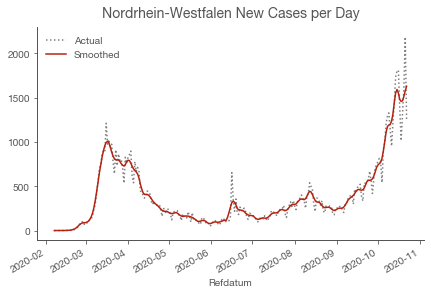

In [3]:
state_name = 'Nordrhein-Westfalen'
#state_name = 'Bayern'

def prepare_cases(cases, cutoff=2):
    # new_cases = cases.diff()
    new_cases = cases

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    idx_start = np.searchsorted(smoothed, cutoff)
    
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = df.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             figsize=(500/72, 300/72))

ax = smoothed.plot(label='Smoothed',
                   legend=True)

ax.get_figure().set_facecolor('w')

## Running the Algorithm

This implements the relationship between $k$ and $R_t-1$, the functional form, and the Bayesian updating.

In [4]:

## connection R and k ##

k = np.array([20, 40, 55, 90])

# We create an array for every possible value of Rt
R_T_MAX = 12
r_t_range = np.linspace(0, R_T_MAX, R_T_MAX*100+1)

# Gamma is 1/serial interval
# https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article
# https://www.nejm.org/doi/full/10.1056/NEJMoa2001316
GAMMA = 1/7

# Map Rt into lambda so we can substitute it into the equation below
# Note that we have N-1 lambdas because on the first day of an outbreak
# you do not know what to expect.
lam = k[:-1] * np.exp(GAMMA * (r_t_range[:, None] - 1))

# Evaluate the likelihood on each day and normalize sum of each day to 1.0
likelihood_r_t = sps.poisson.pmf(k[1:], lam)
likelihood_r_t /= np.sum(likelihood_r_t, axis=0)

def get_posteriors(sr, sigma=0.15):

    # (1) Calculate Lambda
    lam = sr[:-1].values * np.exp(GAMMA * (r_t_range[:, None] - 1))

    
    # (2) Calculate each day's likelihood
    likelihoods = pd.DataFrame(
        data = sps.poisson.pmf(sr[1:].values, lam),
        index = r_t_range,
        columns = sr.index[1:])
    
    # (3) Create the Gaussian Matrix
    process_matrix = sps.norm(loc=r_t_range,
                              scale=sigma
                             ).pdf(r_t_range[:, None]) 

    # (3a) Normalize all rows to sum to 1
    process_matrix /= process_matrix.sum(axis=0)
    
    # (4) Calculate the initial prior
    #prior0 = sps.gamma(a=4).pdf(r_t_range)
    prior0 = np.ones_like(r_t_range)/len(r_t_range)
    prior0 /= prior0.sum()

    # Create a DataFrame that will hold our posteriors for each day
    # Insert our prior as the first posterior.
    posteriors = pd.DataFrame(
        index=r_t_range,
        columns=sr.index,
        data={sr.index[0]: prior0}
    )
    
    # We said we'd keep track of the sum of the log of the probability
    # of the data for maximum likelihood calculation.
    log_likelihood = 0.0

    # (5) Iteratively apply Bayes' rule
    for previous_day, current_day in zip(sr.index[:-1], sr.index[1:]):

        #(5a) Calculate the new prior
        current_prior = process_matrix @ posteriors[previous_day]
        
        #(5b) Calculate the numerator of Bayes' Rule: P(k|R_t)P(R_t)
        numerator = likelihoods[current_day] * current_prior
        
        #(5c) Calcluate the denominator of Bayes' Rule P(k)
        denominator = np.sum(numerator)
        
        # Execute full Bayes' Rule
        posteriors[current_day] = numerator/denominator
        
        # Add to the running sum of log likelihoods
        log_likelihood += np.log(denominator)
    
    return posteriors, log_likelihood

# Note that we're fixing sigma to a value just for the example
posteriors, log_likelihood = get_posteriors(smoothed, sigma=.25)


## Highest density intervals

We construct highest density intervals around the point estimates to visualize the area that spans "most" of the distribution.

In [5]:


def highest_density_interval(pmf, p=.9, debug=False):
    # If we pass a DataFrame, just call this recursively on the columns
    if(isinstance(pmf, pd.DataFrame)):
        return pd.DataFrame([highest_density_interval(pmf[col], p=p) for col in pmf],
                            index=pmf.columns)
    
    cumsum = np.cumsum(pmf.values)
    
    # N x N matrix of total probability mass for each low, high
    total_p = cumsum - cumsum[:, None]
    
    # Return all indices with total_p > p
    lows, highs = (total_p > p).nonzero()
    
    # Find the smallest range (highest density)
    best = (highs - lows).argmin()
    
    low = pmf.index[lows[best]]
    high = pmf.index[highs[best]]
    
    return pd.Series([low, high],
                     index=[f'Low_{p*100:.0f}',
                            f'High_{p*100:.0f}'])

hdi = highest_density_interval(posteriors, debug=True)
hdi.tail()



## highest density intervals

# Note that this takes a while to execute - it's not the most efficient algorithm
hdis = highest_density_interval(posteriors, p=.9)

most_likely = posteriors.idxmax().rename('ML')

# Look into why you shift -1
result = pd.concat([most_likely, hdis], axis=1)

result.tail()


,ML,Low_90,High_90
Refdatum,,,
2020-10-18,0.86,0.57,1.09
2020-10-19,0.98,0.69,1.21
2020-10-20,1.16,0.89,1.40
2020-10-21,1.26,0.99,1.49
2020-10-22,1.23,0.95,1.45


## Plotting $R_t$ 

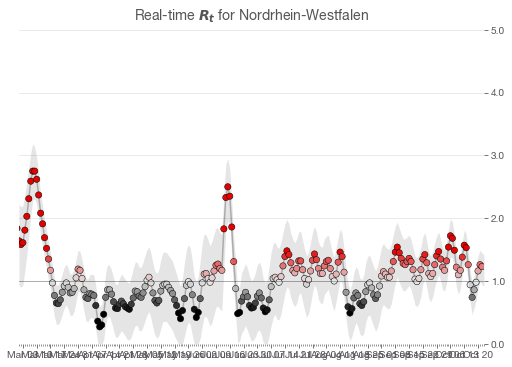

In [7]:

def plot_rt(result, ax, state_name):
    
    ax.set_title(f"{state_name}")
    
    # Colors
    ABOVE = [1,0,0]
    MIDDLE = [1,1,1]
    BELOW = [0,0,0]
    cmap = ListedColormap(np.r_[
        np.linspace(BELOW,MIDDLE,25),
        np.linspace(MIDDLE,ABOVE,25)
    ])
    color_mapped = lambda y: np.clip(y, .5, 1.5)-.5
    
    index = result['ML'].index.get_level_values('Refdatum')
    values = result['ML'].values
    
    # Plot dots and line
    ax.plot(index, values, c='k', zorder=1, alpha=.25)
    ax.scatter(index,
               values,
               s=40,
               lw=.5,
               c=cmap(color_mapped(values)),
               edgecolors='k', zorder=2)
    
    # Aesthetically, extrapolate credible interval by 1 day either side
    lowfn = interp1d(date2num(index),
                     result['Low_90'].values,
                     bounds_error=False,
                     fill_value='extrapolate')
    
    highfn = interp1d(date2num(index),
                      result['High_90'].values,
                      bounds_error=False,
                      fill_value='extrapolate')
    
    extended = pd.date_range(start=pd.Timestamp('2020-03-01'),
                             end=index[-1]+pd.Timedelta(days=1))
    
    ax.fill_between(extended,
                    lowfn(date2num(extended)),
                    highfn(date2num(extended)),
                    color='k',
                    alpha=.1,
                    lw=0,
                    zorder=3)

    ax.axhline(1.0, c='k', lw=1, label='$R_t=1.0$', alpha=.25);
    
    # Formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))
    ax.yaxis.tick_right()
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(0)
    ax.grid(which='major', axis='y', c='k', alpha=.1, zorder=-2)
    ax.margins(0)
    ax.set_ylim(0.0, 5.0)
    ax.set_xlim(pd.Timestamp('2020-03-01'), result.index.get_level_values('Refdatum')[-1]+pd.Timedelta(days=1))
    fig.set_facecolor('w')

    
fig, ax = plt.subplots(figsize=(600/72,400/72))

plot_rt(result, ax, state_name)
ax.set_title(f'Real-time $R_t$ for {state_name}')
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))




## Choosing the optimal maximum likelihood parameter $\sigma$
Before we move from one Bundesland to the whole data, we consider a potential weakness of the approach. In order to avoid overfitting the data on any single Bundesland, we compute and select the $\sigma$ that maximizes $P(k)$ over all the data (every Bundesland).

Done2.


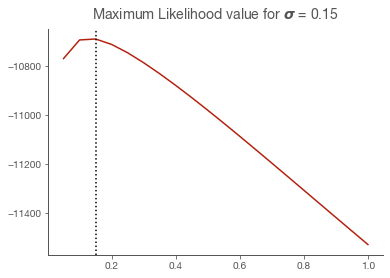

In [8]:
sigmas = np.linspace(1/20, 1, 20)

states_to_process = df

results = {}

for state_name, cases in states_to_process.groupby(level='Bundesland'):
     
    print(state_name)
    new, smoothed = prepare_cases(cases, cutoff=2)
    
    if len(smoothed) == 0:
        new, smoothed = prepare_cases(cases, cutoff=2)
    
    result = {}
    
    # Holds all posteriors with every given value of sigma
    result['posteriors'] = []
    
    # Holds the log likelihood across all k for each value of sigma
    result['log_likelihoods'] = []
    
    for sigma in sigmas:
        posteriors, log_likelihood = get_posteriors(smoothed, sigma=sigma)
        result['posteriors'].append(posteriors)
        result['log_likelihoods'].append(log_likelihood)
    
    # Store all results keyed off of state name
    results[state_name] = result
    clear_output(wait=True)

print('Done1.')



# Each index of this array holds the total of the log likelihoods for
# the corresponding index of the sigmas array.
total_log_likelihoods = np.zeros_like(sigmas)

# Loop through each state's results and add the log likelihoods to the running total.
for state_name, result in results.items():
    total_log_likelihoods += result['log_likelihoods']

# Select the index with the largest log likelihood total
max_likelihood_index = total_log_likelihoods.argmax()

# Select the value that has the highest log likelihood
sigma = sigmas[max_likelihood_index]

# Plot it
fig, ax = plt.subplots()
ax.set_title(f"Maximum Likelihood value for $\sigma$ = {sigma:.2f}");
ax.plot(sigmas, total_log_likelihoods)
ax.axvline(sigma, color='k', linestyle=":")


## compile final results

final_results = None

for state_name, result in results.items():
    print(state_name)
    posteriors = result['posteriors'][max_likelihood_index]
    hdis_90 = highest_density_interval(posteriors, p=.9)
    hdis_50 = highest_density_interval(posteriors, p=.5)
    most_likely = posteriors.idxmax().rename('ML')
    #state = pd.Series(state_name)    
    result = pd.concat([most_likely, hdis_90, hdis_50], axis=1)
    if final_results is None:
        final_results = result
    else:
        final_results = pd.concat([final_results, result])
    clear_output(wait=True)

print('Done2.')



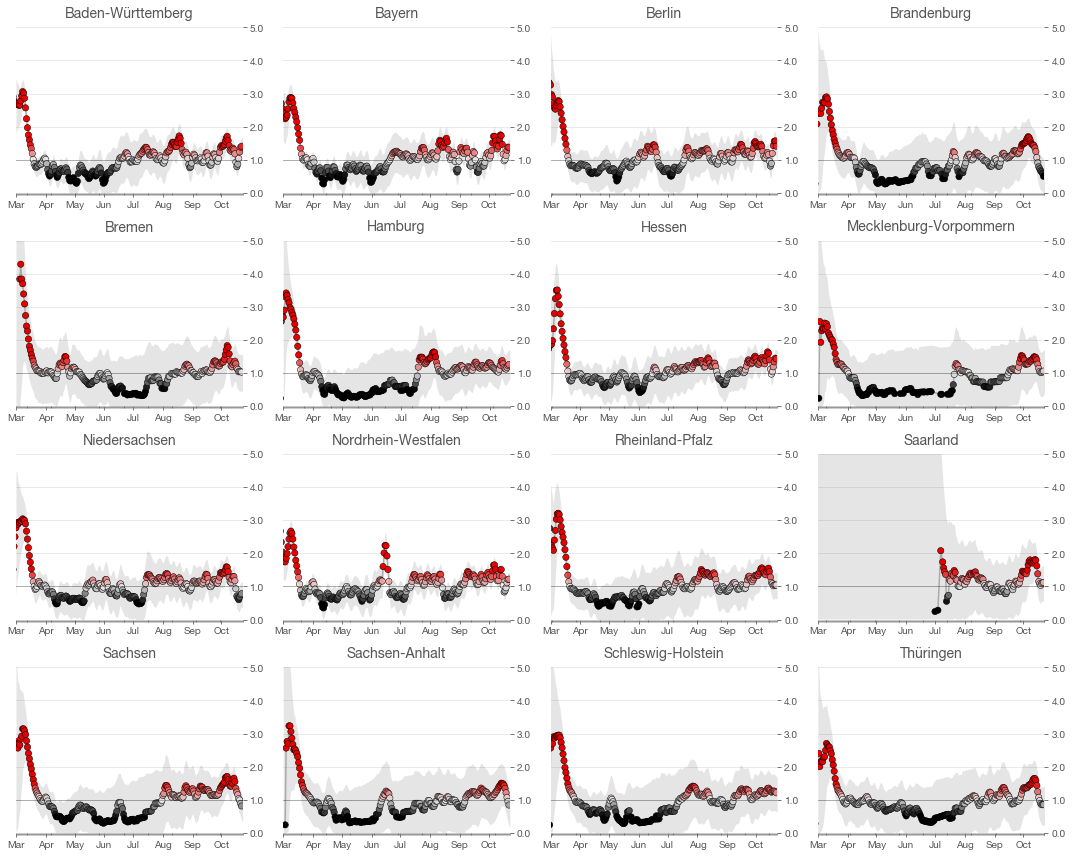

In [9]:
## plot all states

ncols = 4
nrows = int(np.ceil(len(results) / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*3))

for i, (state_name, result) in enumerate(final_results.groupby(by='Bundesland')):
    plot_rt(result.iloc[1:], axes.flat[i], state_name)

fig.tight_layout()
fig.set_facecolor('w')



## Comparison of current $R_t$ across states
An overview of the current $R_t$ in each state, red indicates Bundesländer from East Germany, grey indicates those from West Germany.

Point estimates of the current $R_t$ are all below 1. Considering uncertainty of the estimates, expressed by the error bars, it does not seem sure that the situation is under control in most of the Bundesländer. 

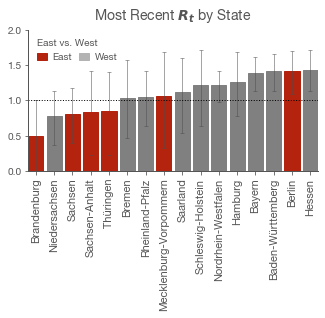

In [10]:


# Since we now use a uniform prior, the first datapoint is pretty bogus, so just truncating it here
final_results = final_results.groupby('Bundesland').apply(lambda x: x.iloc[1:].droplevel(0))

# Uncomment the following line if you'd like to export the data
#final_results.to_csv('rt_old.csv')



## standings

West = [
    'Baden-Württemberg', 'BW',
    'Hamburg', 'HH',
    'Rheinland-Pfalz', 'RP',
    'Saarland', 'SA',
    'Bayern', 'BY',
    'Hessen', 'HE',
    'Nordrhein-Westfalen', 'NW',
    'Niedersachsen', 'NS',
    'Schleswig-Holstein', 'SH',
    'Bremen','BR'
]
East = [
    'Berlin', 'BE',
    'Brandenburg', 'BB',
    'Sachsen', 'SC',
    'Sachsen-Anhalt', 'SA',
    'Mecklenburg-Vorpommern', 'MV',
    'Thüringen', 'TH'
]

FULL_COLOR = [.7,.7,.7]
NONE_COLOR = [179/255,35/255,14/255]
PARTIAL_COLOR = [.5,.5,.5]
ERROR_BAR_COLOR = [.3,.3,.3]



#filtered = final_results.index.get_level_values(0).isin(FILTERED_REGION_CODES)
mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()

def plot_standings(mr, figsize=None, title='Most Recent $R_t$ by State'):
    if not figsize:
        figsize = ((15.9/50)*len(mr)+.1,2.5)
        
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_title(title)
    err = mr[['Low_90', 'High_90']].sub(mr['ML'], axis=0).abs()
    bars = ax.bar(mr.index,
                  mr['ML'],
                  width=.825,
                  color=FULL_COLOR,
                  ecolor=ERROR_BAR_COLOR,
                  capsize=2,
                  error_kw={'alpha':.5, 'lw':1},
                  yerr=err.values.T)

    for bar, state_name in zip(bars, mr.index):
        if state_name in East:
            bar.set_color(NONE_COLOR)
        if state_name in West:
            bar.set_color(PARTIAL_COLOR)

    labels = mr.index.to_series()#.replace({'District of Columbia':'DC'})
    ax.set_xticklabels(labels, rotation=90, fontsize=11)
    ax.margins(0)
    ax.set_ylim(0,2.)
    ax.axhline(1.0, linestyle=':', color='k', lw=1)

    leg = ax.legend(handles=[
                        Patch(label='East', color=NONE_COLOR),
                        #Patch(label='West', color=PARTIAL_COLOR),
                        Patch(label='West', color=FULL_COLOR)
                    ],
                    title='East vs. West',
                    ncol=3,
                    loc='upper left',
                    columnspacing=.75,
                    handletextpad=.5,
                    handlelength=1)

    leg._legend_box.align = "left"
    fig.set_facecolor('w')
    return fig, ax

mr.sort_values('ML', inplace=True)
plot_standings(mr);

